In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 353894340  Analysis (EA + PULS, probably DSCT)


## TESS Data

primarily for epoch / period (amplitude: TBD)

In [8]:
tic = 353894340

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr = sr[sr.mission <= "TESS Sector 73"]  # to limit dataset so that it can be reproudced. Relaxing it would have advantages of having more 2 min cadence data (sectors 73-75 as of 20240417)
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

lcc_tess = sr.download_all()
lcc_tess

SearchResult containing 29 data products.

 #     mission     year   author  exptime target_name distance proposal_id
                                     s                 arcsec             
--- -------------- ---- --------- ------- ----------- -------- -----------
  0 TESS Sector 14 2019 TESS-SPOC    1800   353894340      0.0         N/A
  1 TESS Sector 15 2019 TESS-SPOC    1800   353894340      0.0         N/A
  2 TESS Sector 16 2019 TESS-SPOC    1800   353894340      0.0         N/A
  3 TESS Sector 17 2019 TESS-SPOC    1800   353894340      0.0         N/A
  4 TESS Sector 18 2019 TESS-SPOC    1800   353894340      0.0         N/A
  5 TESS Sector 19 2019 TESS-SPOC    1800   353894340      0.0         N/A
  6 TESS Sector 20 2019 TESS-SPOC    1800   353894340      0.0         N/A
  7 TESS Sector 21 2020 TESS-SPOC    1800   353894340      0.0         N/A
  8 TESS Sector 22 2020 TESS-SPOC    1800   353894340      0.0         N/A
  9 TESS Sector 23 2020 TESS-SPOC    1800   353894340      0.0         N/A
 10 TESS Sector 24 2020 TESS-SPOC    1800   353894340      0.0         N/A
 11 TESS Sector 25 2020 TESS-SPOC    1800   353894340      0.0         N/A
 12 TESS Sector 26 2020 TESS-SPOC    1800   353894340      0.0         N/A
 13 TESS Sector 40 2021 TESS-SPOC     600   353894340      0.0         N/A
 14 TESS Sector 41 2021 TESS-SPOC     600   353894340      0.0         N/A
 15 TESS Sector 47 2021 TESS-SPOC     600   353894340      0.0         N/A
 16 TESS Sector 48 2022 TESS-SPOC     600   353894340      0.0         N/A
 17 TESS Sector 49 2022 TESS-SPOC     600   353894340      0.0         N/A
 18 TESS Sector 50 2022 TESS-SPOC     600   353894340      0.0         N/A
 19 TESS Sector 51 2022 TESS-SPOC     600   353894340      0.0         N/A
 20 TESS Sector 52 2022 TESS-SPOC     600   353894340      0.0         N/A
 21 TESS Sector 54 2022 TESS-SPOC     600   353894340      0.0         N/A
 22 TESS Sector 55 2022 TESS-SPOC     600   353894340      0.0         N/A
 23 TESS Sector 56 2022       QLP     200   353894340      0.0         N/A
 24 TESS Sector 57 2022 TESS-SPOC     200   353894340      0.0         N/A
 25 TESS Sector 58 2022 TESS-SPOC     200   353894340      0.0         N/A
 26 TESS Sector 59 2022       QLP     200   353894340      0.0         N/A
 27 TESS Sector 60 2022 TESS-SPOC     200   353894340      0.0         N/A
 28 TESS Sector 73 2023      SPOC     120   353894340      0.0      G06021

LightCurveCollection of 29 objects:
    0: <TessLightCurve LABEL="TIC 353894340" SECTOR=14 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 353894340" SECTOR=15 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 353894340" SECTOR=16 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 353894340" SECTOR=17 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 353894340" SECTOR=18 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 353894340" SECTOR=19 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 353894340" SECTOR=20 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 353894340" SECTOR=21 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 353894340" SECTOR=22 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 353894340" SECTOR=23 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 353894340

In [9]:
# List of all TCEs of the TIC
display(HTML(lket.get_tic_meta_in_html(tic, download_dir=lk_download_dir)))

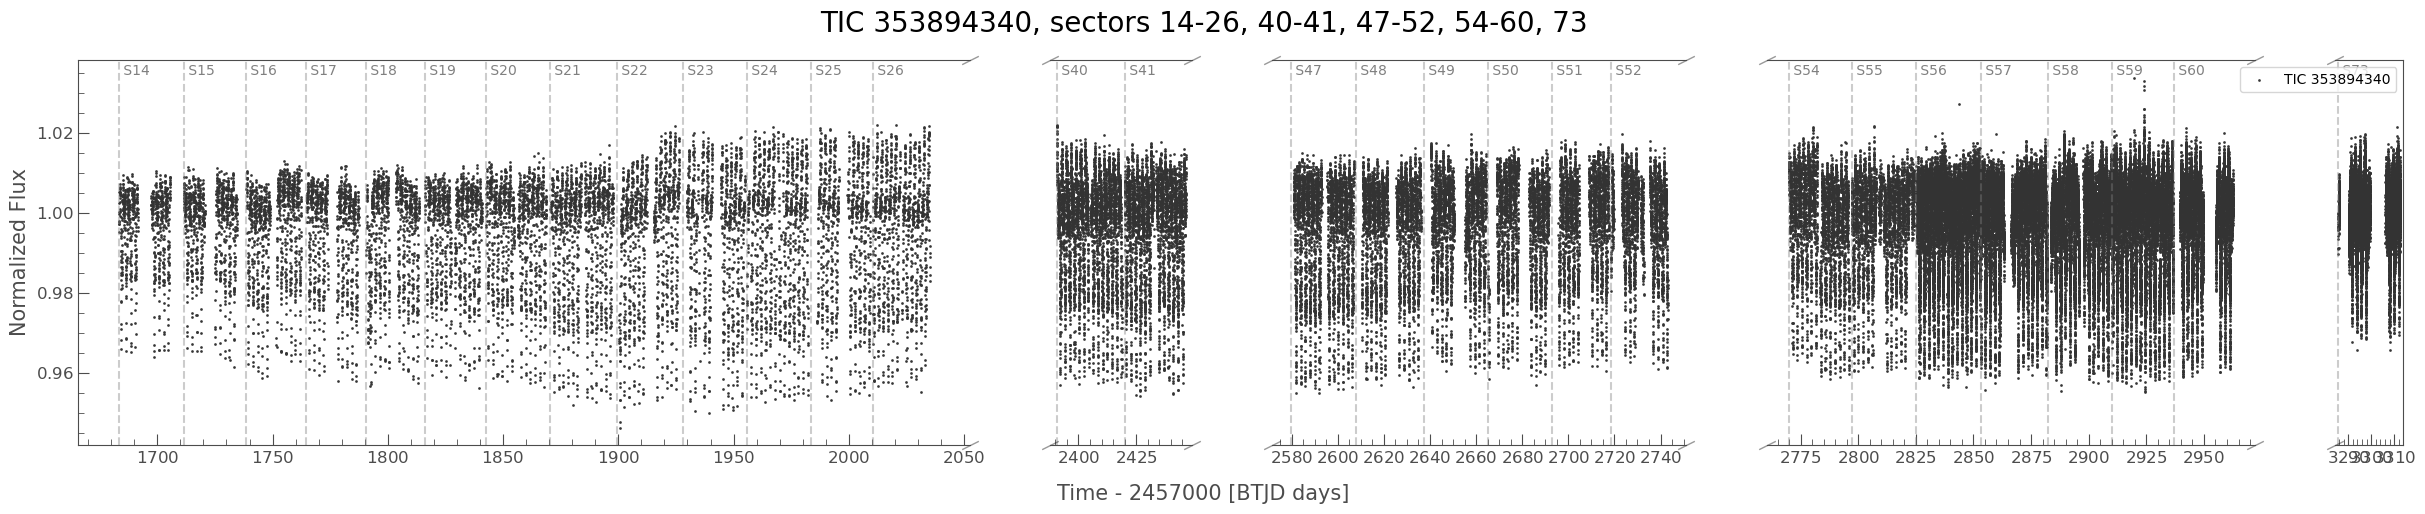

In [10]:
lc = lke.stitch(
    lcc_tess,
    ignore_incompatible_column_warning=True,    
)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=4, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);

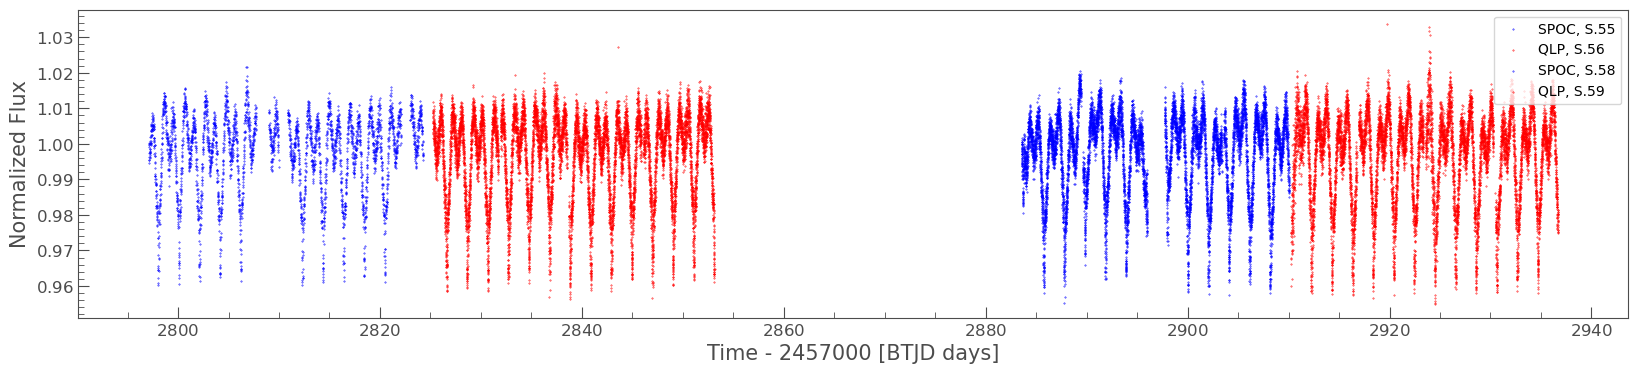

In [11]:
# inspect to ensure QLP data and SPOC data is comparable
ax = tplt.lk_ax(figsize=(20, 4))
for lc in lke.of_sectors(lcc_tess, 55, 56, 58, 59):
    color = "blue" if lc.author == "SPOC" else "red"
    ax = tplt.scatter(lc.normalize(), label=f"{lc.author}, S.{lc.sector}", ax=ax, s=0.5, c=color);
ax.legend(loc="upper right");

---

## Gaia DR3 info (coordinate, etc.)

In [6]:
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)
primary_name = f"TIC {tic}"  # Primary data is from TESS and ASAS-SN (but there is no ASAS-SN V identifier)

## ASAS-SN data

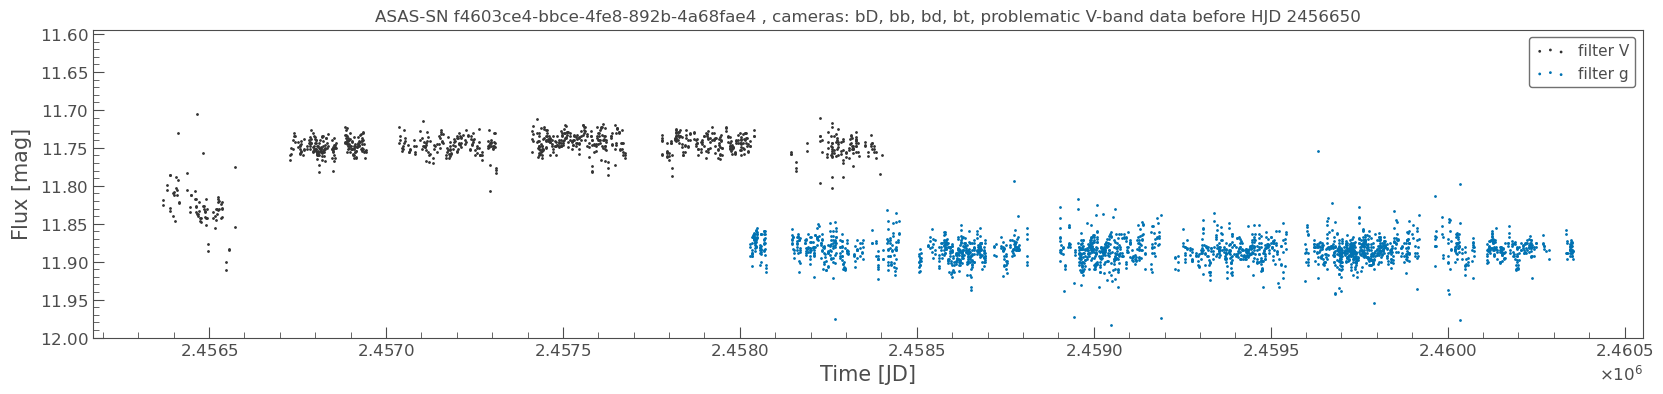

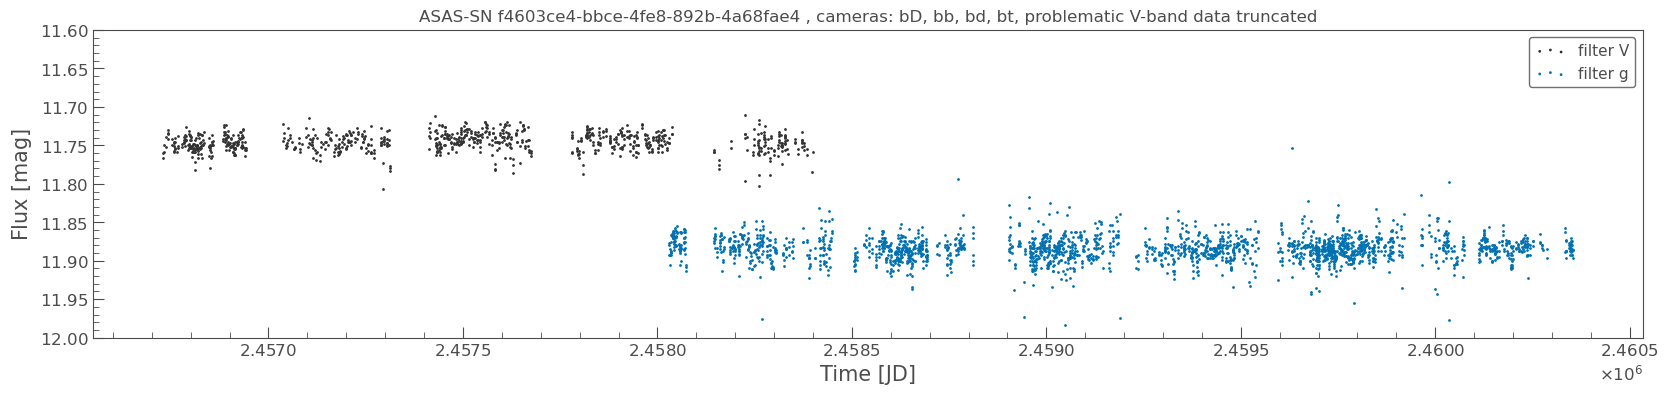

In [20]:
import lightkurve_ext_readers as lker
reload(lker)

# SkyPatrol v1 , its result has more scatter
# https://asas-sn.osu.edu/sky-patrol/coordinate/f4603ce4-bbce-4fe8-892b-4a68fae4464c
lc = (
    lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic353894340_asas_sn_skypatrol1_light_curve_f4603ce4-bbce-4fe8-892b-4a68fae4464c.csv")
    .select_flux("mag")
)

ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.scatter_partition_by(lc, "filter", ax=ax);
ax.set_ylim(12.0, None);
ax.set_title(ax.get_title() + ", problematic V-band data before HJD 2456650");

lc = lc.truncate(2456650, None);
ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.scatter_partition_by(lc, "filter", ax=ax);
ax.set_ylim(12.0, None);
ax.set_title(ax.get_title() + ", problematic V-band data truncated");

lc_asassn = lc  # keep the reference in a meaninfgul name for use in subsequent cells

In [ ]:
# Do not use SkyPatrol v2, the data is less reliable per Sebastián Otero
# SkyPatrol v2, g band data is as if it has been shifted to V (magnitudes comparable)
# http://asas-sn.ifa.hawaii.edu/skypatrol/objects/223338426798
#
# in SkyPatrol v1, g-band data is fainter than that of V-band
# SkyPartol v2 paper section 5 suggests g-band data begins to saturate around 12.5 mag g,
# and recommends using v1 for gmag <= 11.5
#   https://ui.adsabs.harvard.edu/abs/arXiv:2304.03791
#
# For the target here, gmag is in the saturation range, but still usable per SkyPartol v2.0 guideline
# It won't be used for magnitude / amplitude measurement so I suppose it's okay.
# lc = (
#     lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic353894340_asas_sn_skypatrol2_223338426798-light-curves.csv")
#     .select_flux("mag")
# )
# # SkyPatrol v2 data: g band seems to have been calibrated or shfited to V band
# # ax = tplt.lk_ax()
# ax2 = tplt.lk_ax(figsize=(20, 4))
# for filter, offset in zip(["V", "g" ], [0, -0.0]):
#     _lcz = lc[lc.filter == filter]  # or "g"
#     _lcz = _lcz + offset * u.mag
#     # ax = tplt.scatter(_lcz.fold(period=2.039652, epoch_time=Time(3287.5580, format="btjd").to_value("jd")), label=f"ASAS-SN {filter}", ax=ax);
#     ax2 = tplt.scatter(_lcz, label=f"ASAS-SN {filter}", ax=ax2);
# # ax.set_ylim(11.8, 11.67);
# # ax.set_ylim(11.90, 11.76);

## Combining TESS and ASAS-SN data

TESS # data points: 122353
ASAS-SN V # data points: 880
ASAS-SN g # data points: 2253


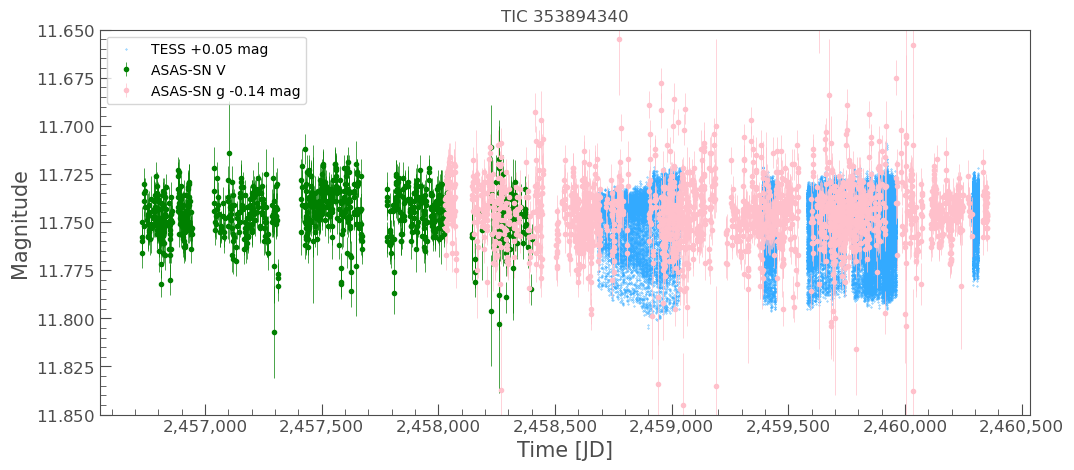

In [33]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True,    )

lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "ASAS-SN": lc_asassn,
    }, 
    shift_to="ASAS-SN V")

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name);
ax.set_ylim(11.85, 11.65);

## Determine period by using both TESS and ASAS-SN data

In [24]:
# epoch=3287.5580, duration_hr=3.3745, period=2.039652, label="s0073-s0073:TCE1",

#
# Tentative Eclipse parameters, from s0003-s0073:TCE1 above
#

period_tce = 2.039652

epoch_time_btjd = 3287.5580
epoch_time_hjd = lke.to_hjd_utc(Time(epoch_time_btjd, format="btjd"), target_coord).value
epoch_time_hjd = round(epoch_time_hjd, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough

duration_hr = 3.3745

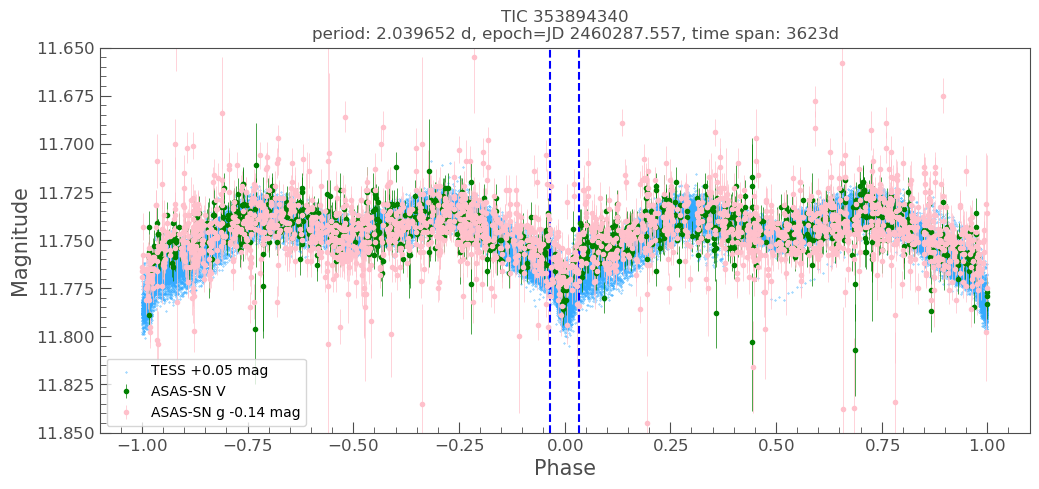

In [32]:
reload(lkem)
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_tce,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);

ax.set_ylim(11.85, 11.65);
# ax.set_xlim(-0.1, 0.1);  # to see primary in details

C:\dev\_juypter\PH_TESS_LightCurveViewer\targets\..\lightkurve_ext_pg.py:350: UserWarning: validate_bls_n_report() cannot calculate FAP, because the depdent package transitleastsquares is not installed
  warnings.warn(


max power duration factor: 1.14


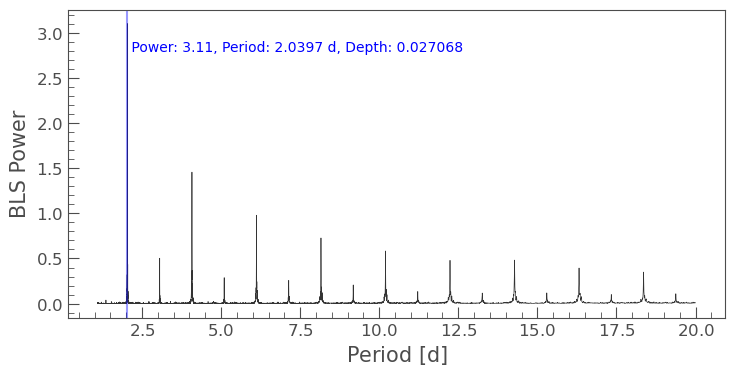

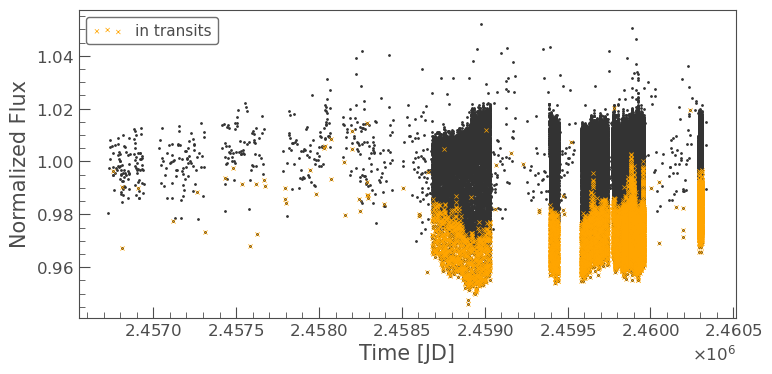

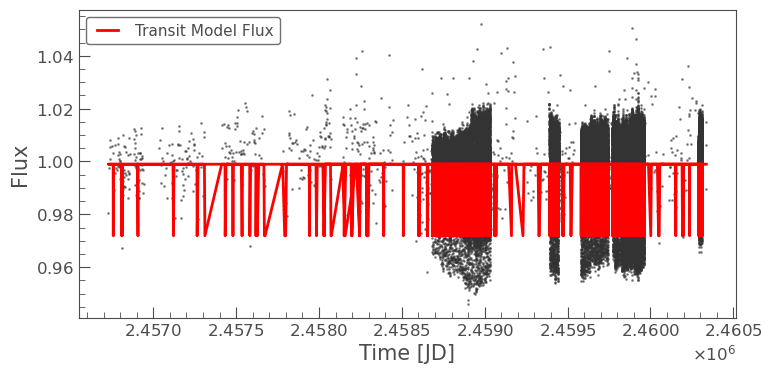

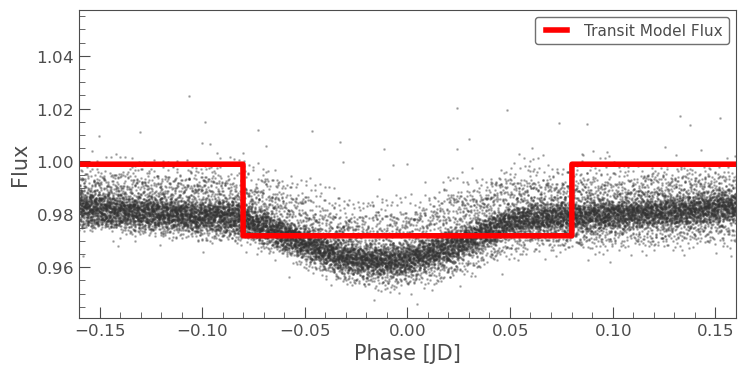

In [16]:
bls_result = lke_pg_runner.run_bls(
    # convert the TESS + ZTF lightcurve to normalized flux for BLS
    lke.to_normalized_flux_from_mag(lk.LightCurveCollection(lc_combined_dict.values()).stitch(corrector_func=lambda lc: lk.LightCurve(time=lc.time, flux=lc.flux, flux_err=lc.flux_err))),
    pg_kwargs=dict(
        minimum_period=1.1,  # avoid matching 1/2 he period
        maximum_period=20,  
        frequency_factor=500,            
        duration=[duration_hr / 24 * f for f in [0.95, 0.975, 0.9875, 1, 1.0125, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
    ),
)

print("max power duration factor:", round(bls_result.pg.duration_at_max_power.to(u.h).value / duration_hr, 2))
# tplt.beep();

In [ ]:
# export LC truncated around primary eclipses for AoV test

# lc = bls_result.lc_f.truncate(-0.25, 0.25)
# lc.scatter();
# lk.LightCurve(time=lc.time_original, flux=lc.flux, flux_err=lc.flux_err).to_csv(f"tmp/{primary_name}_trunc_primary.csv")

123346 3607.1379765482943 2456730.0279373 2460337.1658907
Period at max: 2.0396662 d
lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
          default_view                            period      
             ls_method                              fast      
frequency_at_max_power                            0.4903 1 / d
             max_power                            0.0111      
               nyquist                          215.9827 1 / d
   period_at_max_power                            2.0397     d
             frequency                    array (71038,) 1 / d
                period                    array (71038,)     d
                 power                    array (71038,)      
                 label                <class 'NoneType'>      
                  meta <class 'collections.OrderedDict'>     

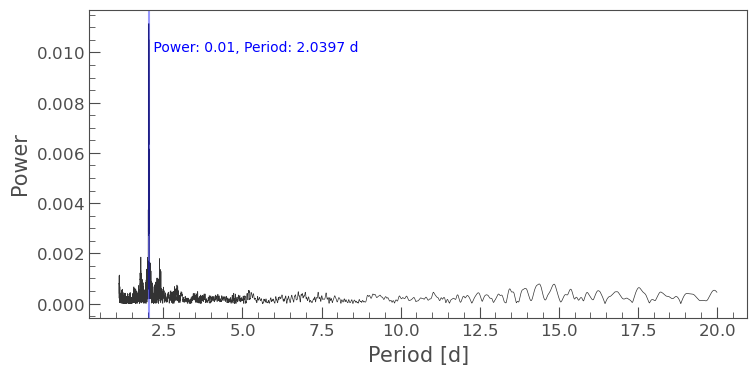

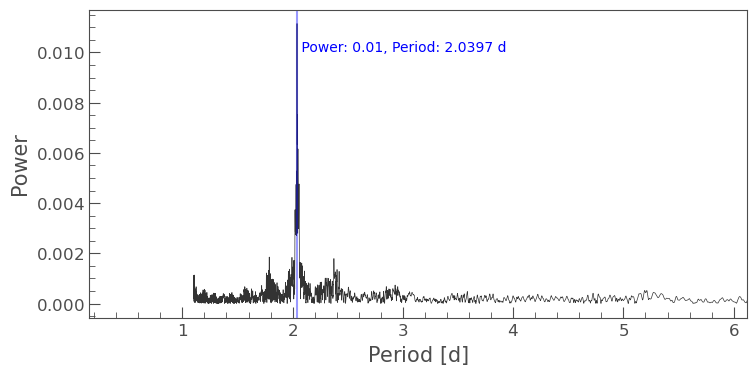

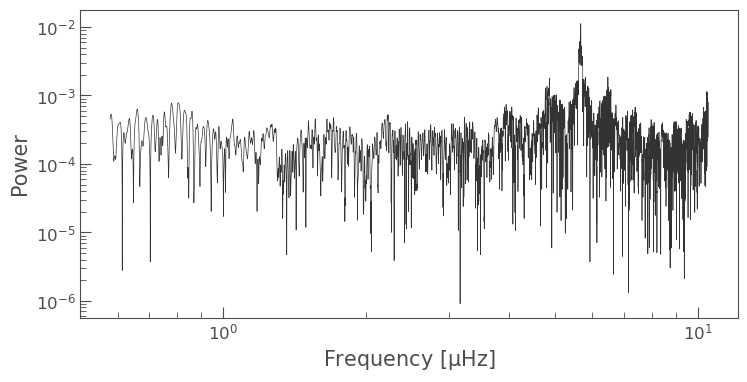

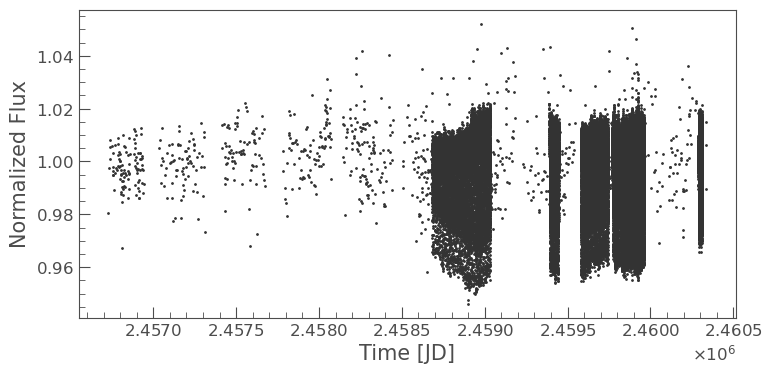

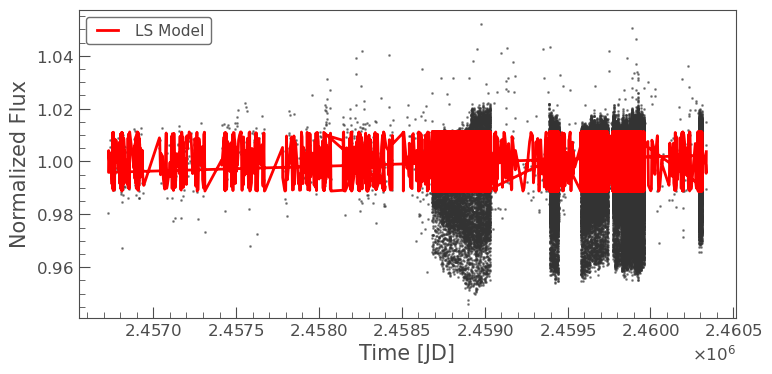

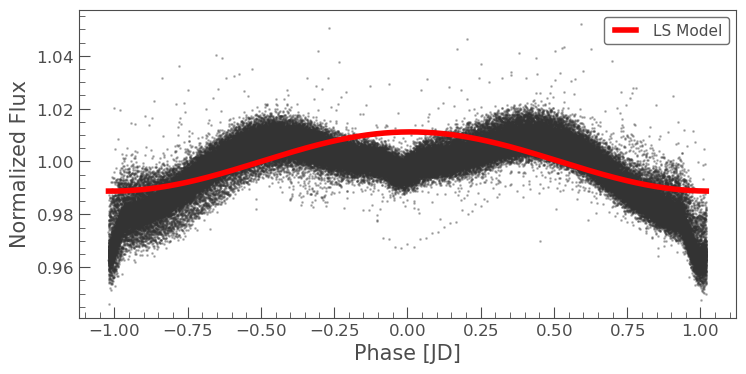

In [21]:
lc = lke.to_normalized_flux_from_mag(lk.LightCurveCollection(lc_combined_dict.values()).stitch(corrector_func=lambda lc: lk.LightCurve(time=lc.time, flux=lc.flux, flux_err=lc.flux_err)))
pg = (
    lc    
    .to_periodogram(method="lombscargle",
                      minimum_period=1.1,                    
                     maximum_period=20,
                    # ls_method="fastchi2", nterms=12,
                    oversample_factor=50,  # default: 5
                      )
     )
print(len(lc), lc.time.max() - lc.time.min(), lc.time.min(), lc.time.max(), )
print(f"Period at max: {pg.period_at_max_power:.7f}")
pg.show_properties();

ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=80);
# ax.set_xlim(0, 16);

# zoom in
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=3);

# ---

# ax = pg.plot(view="frequency");  # frequency view
# ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

# frequency in log scale / microhertz
# often useful for solar type oscillator, 
ax = pg.plot(view="frequency", unit=u.microhertz, scale="log"); 

# ---

axs, lcs = lke_pg.plot_lc_with_model(
    lc.normalize(),
    pg, 
    # period=pg.period_at_max_power * 2,   # custom period
    also_return_lcs=True);

Adopted period:  2.03965


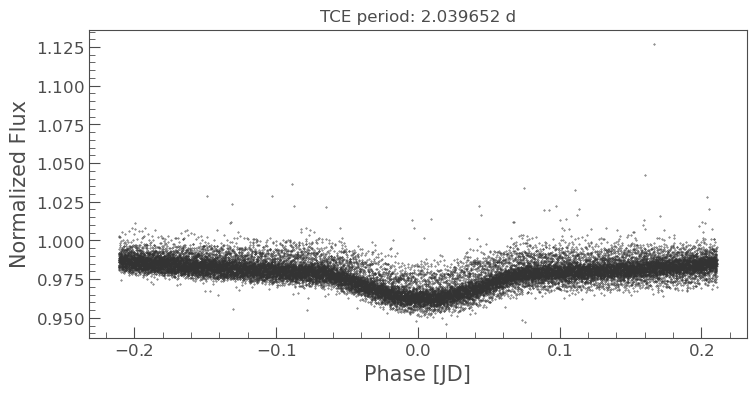

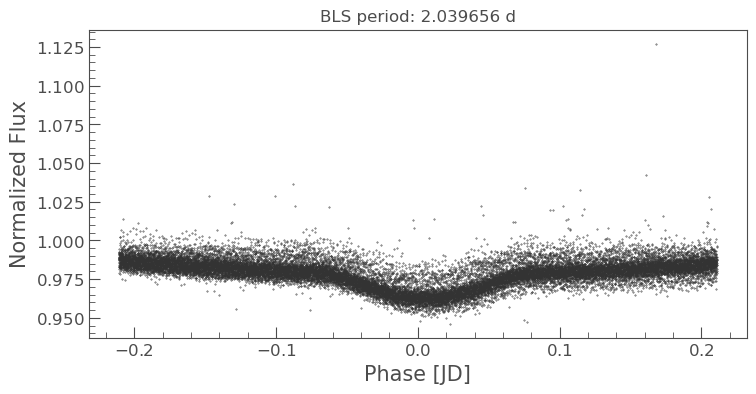

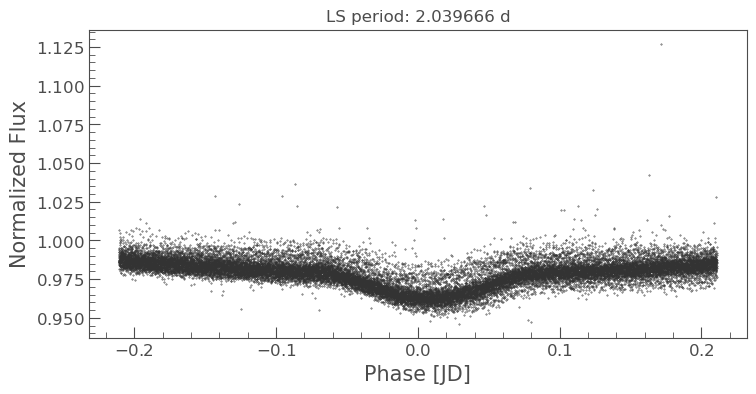

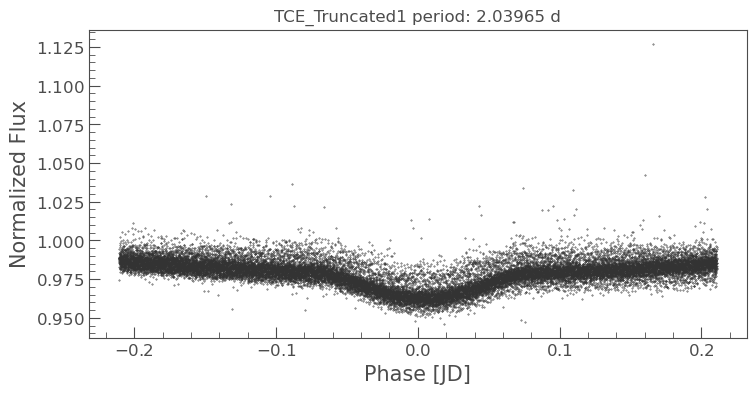

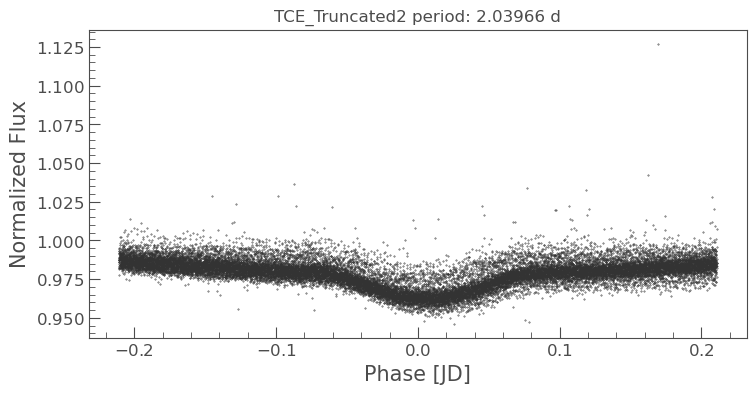

In [35]:
period_bls = 2.039656 # 2.0396556528533254 , FWHM: 0.00093 , frequency_factor=500
period_ls  = 2.039666   
# period_aov = 1.65116  # rounded from ~1.651157 , bins=16
period_trunc1 = 2.03965
period_trunc2 = 2.03966

lc = lke.to_normalized_flux_from_mag(lk.LightCurveCollection(lc_combined_dict.values()).stitch(corrector_func=lambda lc: lk.LightCurve(time=lc.time, flux=lc.flux, flux_err=lc.flux_err)))

for per_method, per in dict(TCE=period_tce, BLS=period_bls, LS=period_ls, TCE_Truncated1=period_trunc1, TCE_Truncated2=period_trunc2, ).items():
    lc_f = lc.fold(period=per, epoch_time=epoch_time_hjd)
    lc_f = lc_f.truncate(0 - 1.5 * duration_hr / 24, 0 + 1.5 * duration_hr / 24);
    ax = tplt.scatter(lc_f, s=0.5);
    ax.set_title(f"{per_method} period: {per} d")

# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = period_trunc1  
print("Adopted period: ", period_final)

## Determine Amplitude (range)

['11.68', '11.74', '11.71']


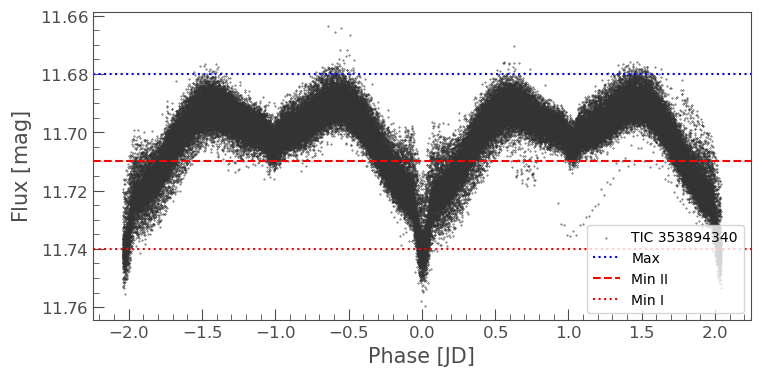

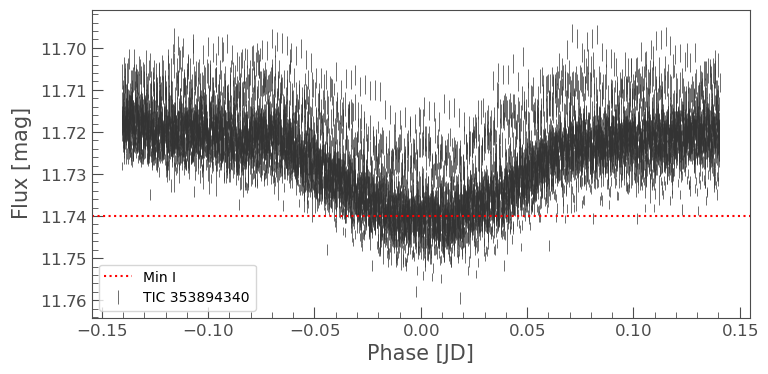

In [36]:
# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict["TESS"]
lc = lc - lc.flux_shift
max_flux_mag = lc.flux.min().value  #
min_flux_mag = lc.flux.max().value
max_flux_mag = 11.68 # from inspection
min_flux_mag = 11.74 # from inspection

# fold around Min II, find the min flux
lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_hjd + period_final / 2, period=period_final).truncate(0 - 15/24/60, 0 + 15/24/60) .truncate(None, 11.71, column="flux")
min_ii_flux_mag = lc_zoom_min_ii.flux.max().value
# min_ii_flux_mag = 13.80  # override from visual inspection

lc_f = lc.fold(epoch_time=epoch_time_hjd, period=period_final * 2)  # 2x period plot
ax = tplt.scatter(lc_f, s=0.5);
ax.axhline(max_flux_mag, c="blue", linestyle="dotted", label="Max")
ax.axhline(min_ii_flux_mag, c="red", linestyle="dashed", label="Min II")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend();

lc_f_zoom_min_i = lc_f.truncate(0 - duration_hr / 24, 0 + duration_hr / 24)
ax = tplt.errorbar(lc_f_zoom_min_i);
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend();

print([f"{v:.2f}" for v in [max_flux_mag, min_flux_mag, min_ii_flux_mag]])

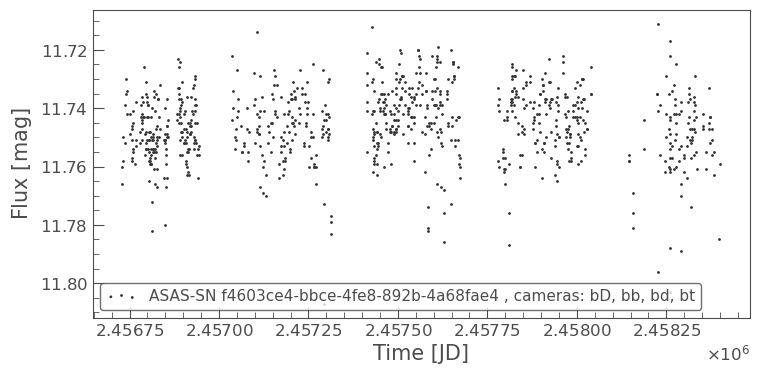

In [38]:
tplt.scatter(lc);

['11.73', '11.78', '11.75']


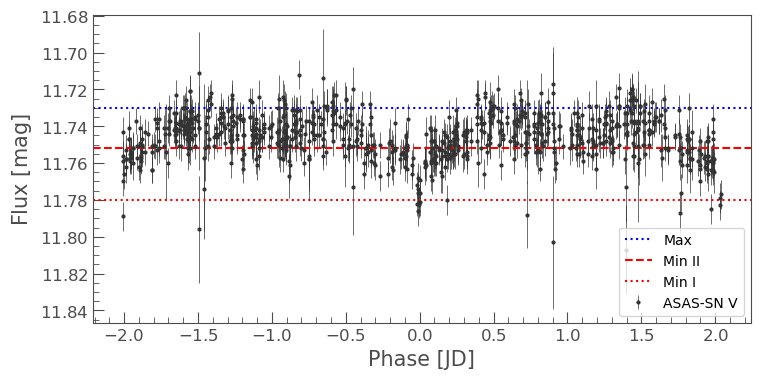

In [60]:
# From ASAS-SN V data, 
# the result is comparable to TESS data. So I'll use them (V mag preferrable)


lc = lc_combined_dict["ASAS-SN V"].copy()
lc.label = "ASAS-SN V"
# max_flux_mag = lc.truncate(11.812, None, column="flux").flux.min().value  #
max_flux_mag = lc.flux.min().value
min_flux_mag = lc.flux.max().value

max_flux_mag = 11.73
min_flux_mag = 11.78

# fold around Min II, find the min flux
lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_hjd + period_final / 2, period=period_final).truncate(0 - 30/24/60, 0 + 30/24/60)
min_ii_flux_mag = lc_zoom_min_ii.flux.max().value
# min_ii_flux_mag = 13.80  # override from visual inspection

lc_f = lc.fold(epoch_time=epoch_time_hjd, period=period_final * 2)  # 2x period plot
ax = tplt.errorbar(lc_f, marker="o");
ax.axhline(max_flux_mag, c="blue", linestyle="dotted", label="Max")
ax.axhline(min_ii_flux_mag, c="red", linestyle="dashed", label="Min II")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend(loc="lower right");
print([f"{v:.2f}" for v in [max_flux_mag, min_flux_mag, min_ii_flux_mag]])

## Pulsation Analysis (TESS data only)

### Evaluate possible additional periods from the latest sector of 2-minute cadece data

Period at max: 1.0248064 d
lightkurve.Periodogram properties:
      Attribute         Description   Units
---------------------- -------------- -----
                nterms              1      
              targetid      353894340      
          default_view      frequency      
                 label  TIC 353894340      
             ls_method           fast      
frequency_at_max_power         0.9758 1 / d
             max_power         0.0079      
               nyquist       360.0003 1 / d
   period_at_max_power         1.0248     d
             frequency array (48329,) 1 / d
                period array (48329,)     d
                 power array (48329,)      
                  meta <class 'dict'>      


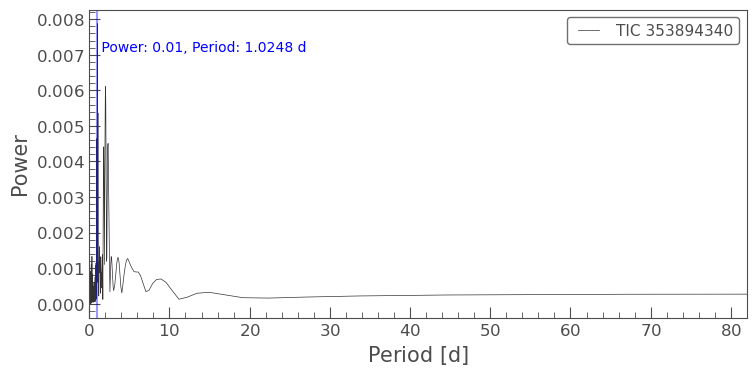

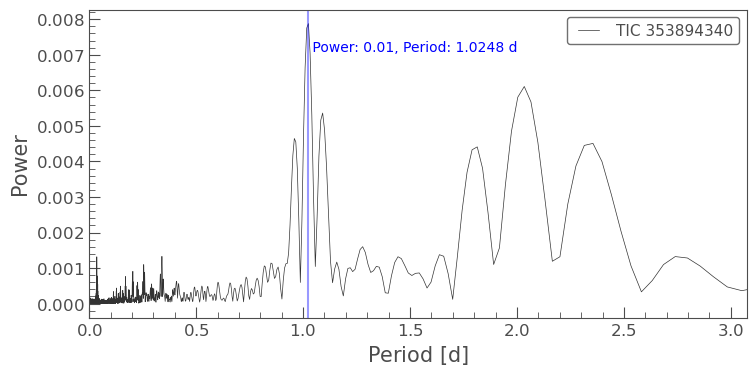

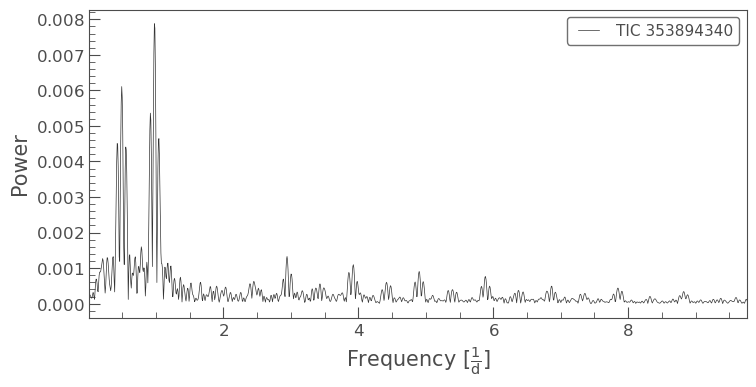

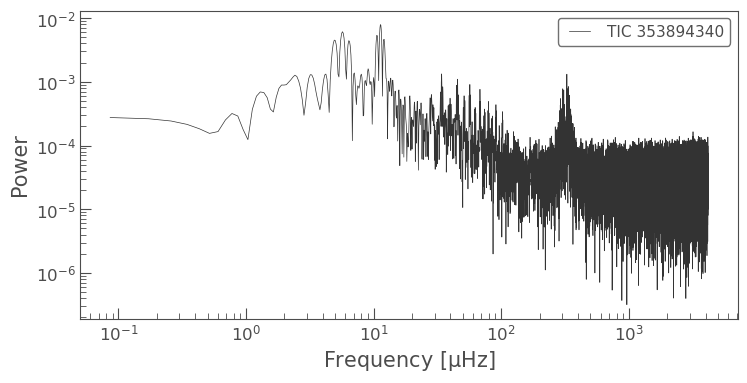

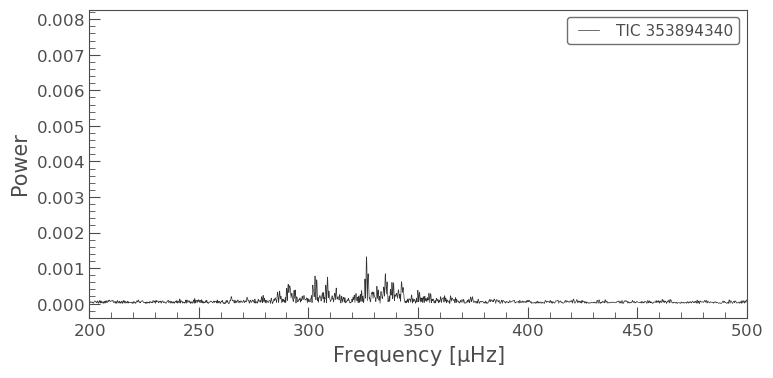

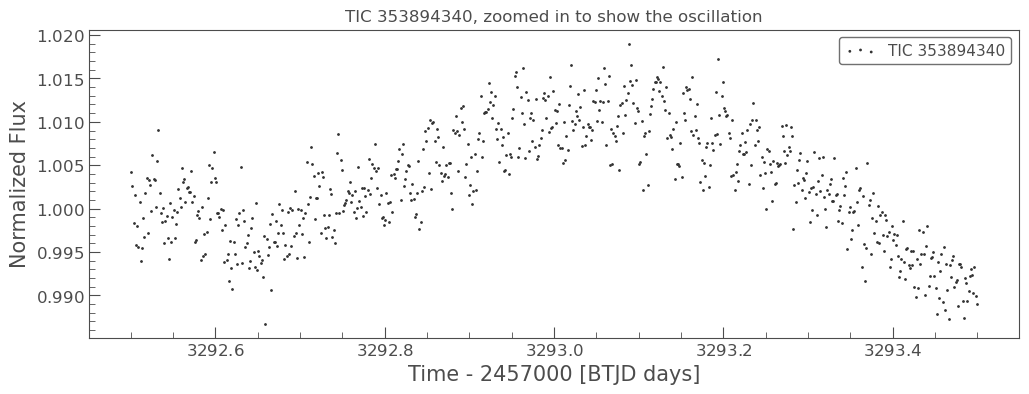

In [50]:
lc = of_sector(lcc_tess, 73).normalize()

pg = (
    lc
    .to_periodogram(method="lombscargle",
                    # ls_method="fastchi2", nterms=12,
                    # oversample_factor=5,  # default: 5
                      )
     )
print(f"Period at max: {pg.period_at_max_power:.7f}")
pg.show_properties();

ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=80);
# ax.set_xlim(0, 16);

# zoom in
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=3);

# ---

ax = pg.plot(view="frequency");  # frequency view
ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

# frequency in log scale / microhertz
# often useful for solar type oscillator, 
ax = pg.plot(view="frequency", unit=u.microhertz, scale="log"); 


# frequency in log scale / microhertz
# often useful for solar type oscillator, 
ax = pg.plot(view="frequency", unit=u.microhertz); 
ax.set_xlim(200, 500);


ax = tplt.lk_ax(figsize=(12, 4))
ax = lc.truncate(3292.5, 3293.5).scatter(ax=ax);
ax.set_title(f"{lc.label}, zoomed in to show the oscillation");

### Detrend the whole lightcurve to determine pulsation period, amplitude

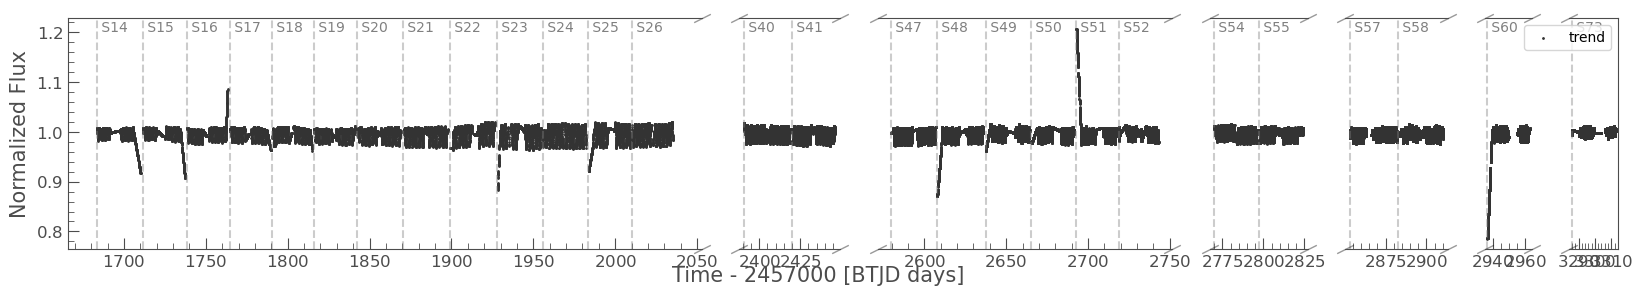

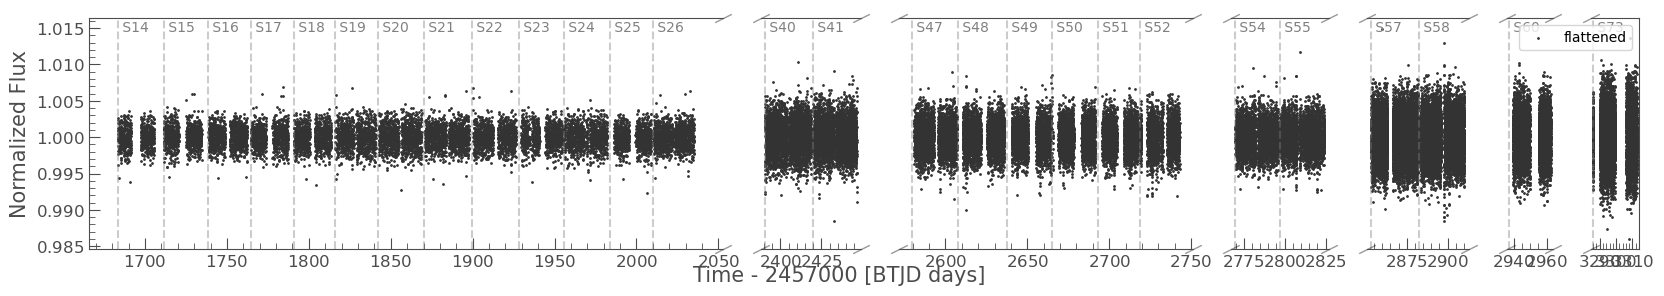

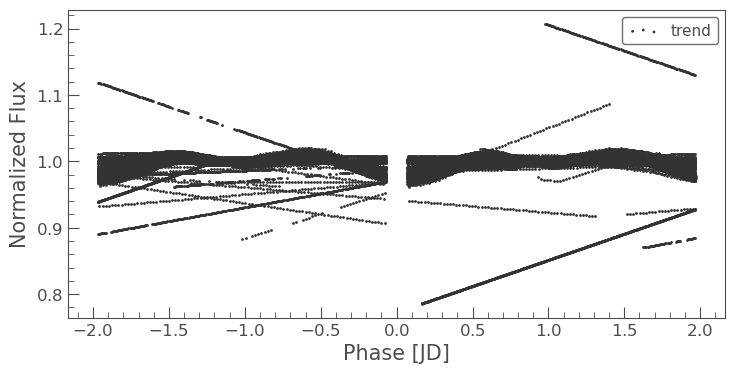

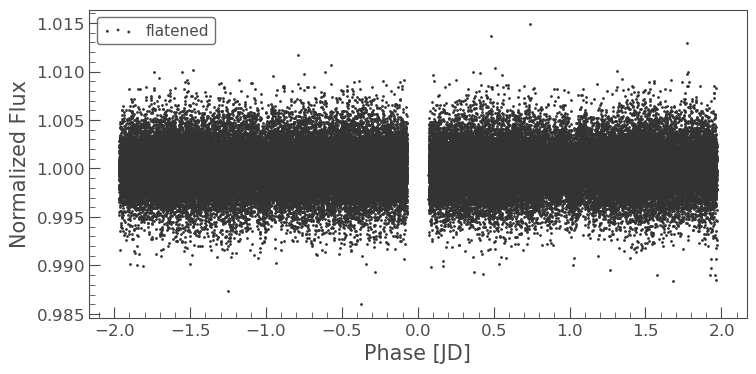

In [51]:
window_length_time = 0.2 * u.d

lcc_f, lcc_t = [], []  # flattened and trend
for lc in lke.select(lcc_tess, lambda lc: lc.author == "SPOC"):  # use SPOC and TESS-SPOC data only
    mask = lc.create_transit_mask(period=period_final, transit_time=epoch_time_btjd, duration=duration_hr/24)
    lc = lc[~mask]
    window_length_cadence = lke.to_window_length_for_cadence(window_length_time, cadence=lke.estimate_cadence(lc, unit=u.min))
    lc_f, lc_t = lc.flatten(window_length_cadence, return_trend=True)
    lcc_f.append(lc_f)
    lcc_t.append(lc_t)


lc_flattened = lke.stitch(lk.LightCurveCollection(lcc_f))
lc_trend = lke.stitch(lk.LightCurveCollection(lcc_t))

axs = tplt.plot_skip_data_gap(lc_trend, figsize=(20, 3), label="trend");
axs = tplt.plot_skip_data_gap(lc_flattened, figsize=(20, 3), label="flattened");

tplt.scatter(lc_trend.fold(epoch_time=epoch_time_btjd, period=period_final * 2), label="trend");
tplt.scatter(lc_flattened.fold(epoch_time=epoch_time_btjd, period=period_final * 2), label="flatened");

16184 26.84992648160369 3285.797962810602 3312.6478892922055
Period at max: 0.0354477 d
lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
              targetid                         353894340      
          default_view                         frequency      
                 label                     TIC 353894340      
             ls_method                              fast      
frequency_at_max_power                           28.2106 1 / d
             max_power                             0.001      
               nyquist                           72.0011 1 / d
   period_at_max_power                            0.0354     d
             frequency                   array (586543,) 1 / d
                period                   array (586543,)     d
                 power                   array (586543,)  

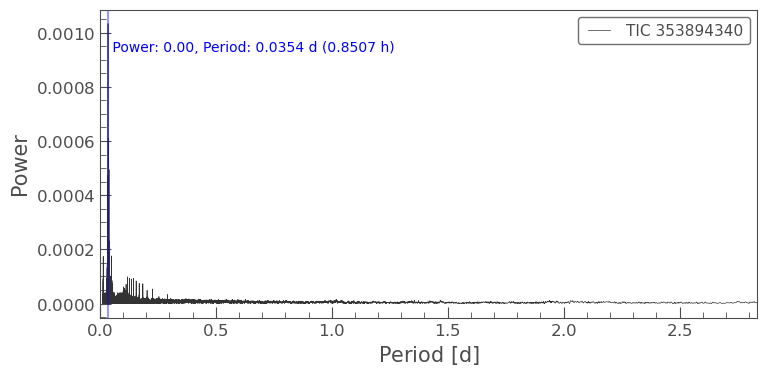

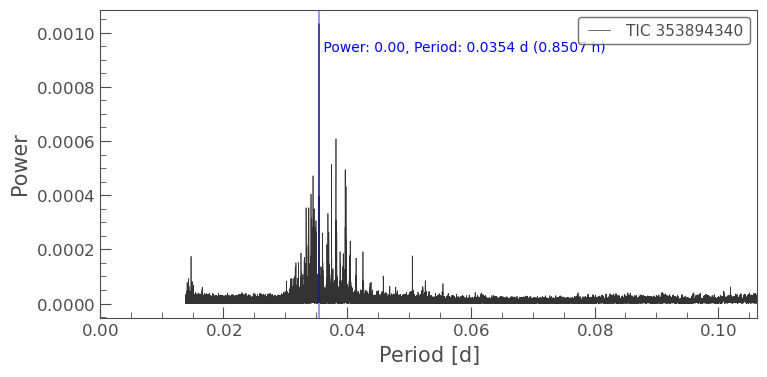

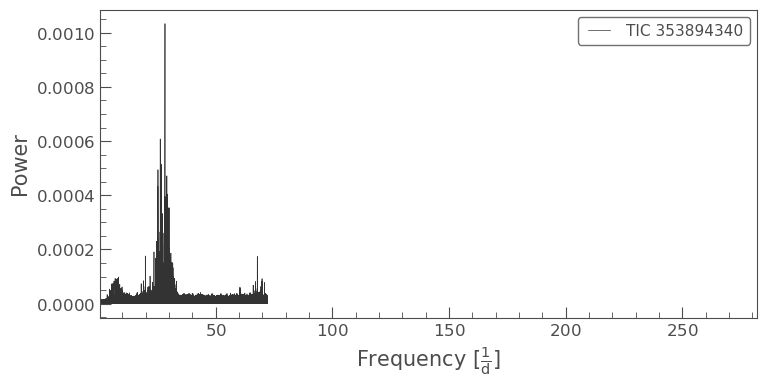

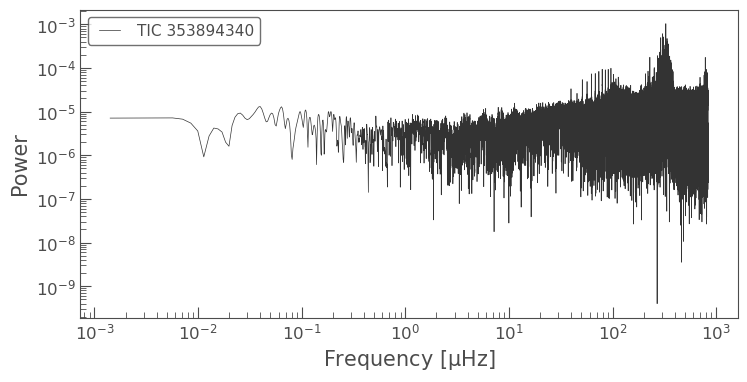

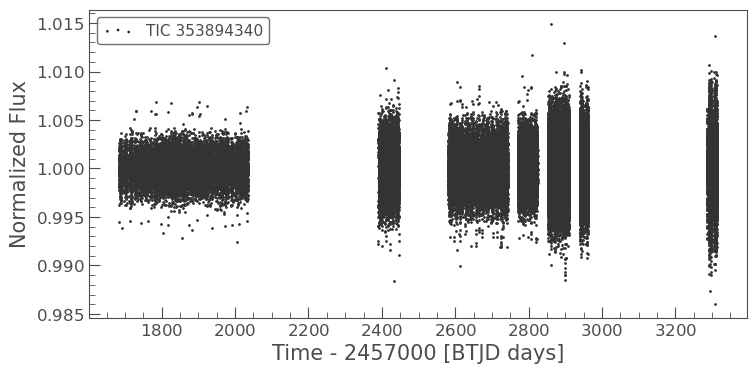

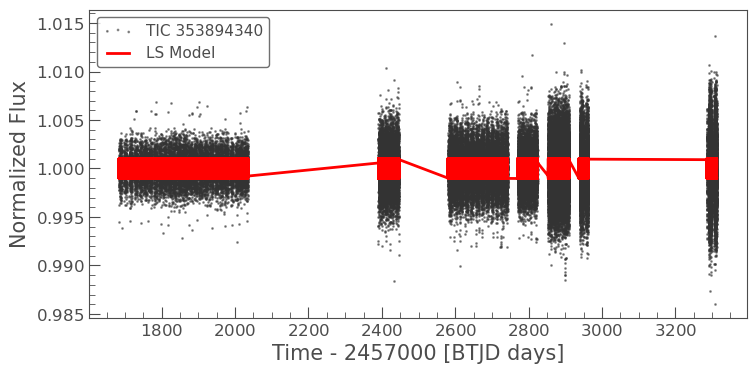

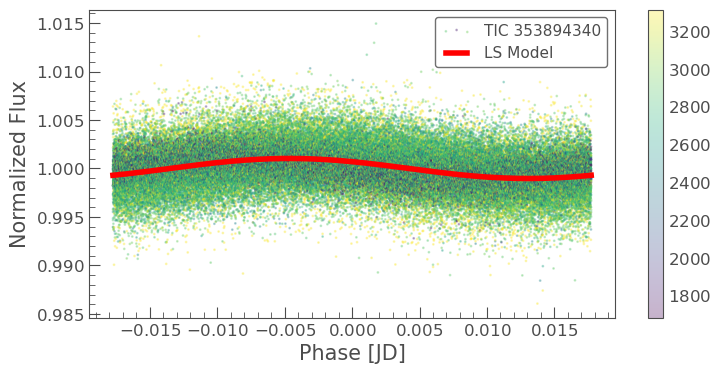

In [52]:
pg = (
    lc_flattened
    .to_periodogram(method="lombscargle",
                    # ls_method="fastchi2", nterms=12,
                    # oversample_factor=5,  # default: 5
                      )
     )
print(len(lc), lc.time.max() - lc.time.min(), lc.time.min(), lc.time.max(), )
print(f"Period at max: {pg.period_at_max_power:.7f}")
pg.show_properties();

ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=80);
# ax.set_xlim(0, 16);

# zoom in
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=3);

# ---

ax = pg.plot(view="frequency");  # frequency view
ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

# frequency in log scale / microhertz
# often useful for solar type oscillator, 
ax = pg.plot(view="frequency", unit=u.microhertz, scale="log"); 

# ---

axs, lcs = lke_pg.plot_lc_with_model(
    lc_flattened.normalize(),
    pg, 
    # period=pg.period_at_max_power * 2,   # custom period
    also_return_lcs=True);

Binned Max, min, amp: 11.698179422592176 mag 11.70089019366105 mag 0.0027107710688731856 mag
Binned max phase: 0.0008367223108273852


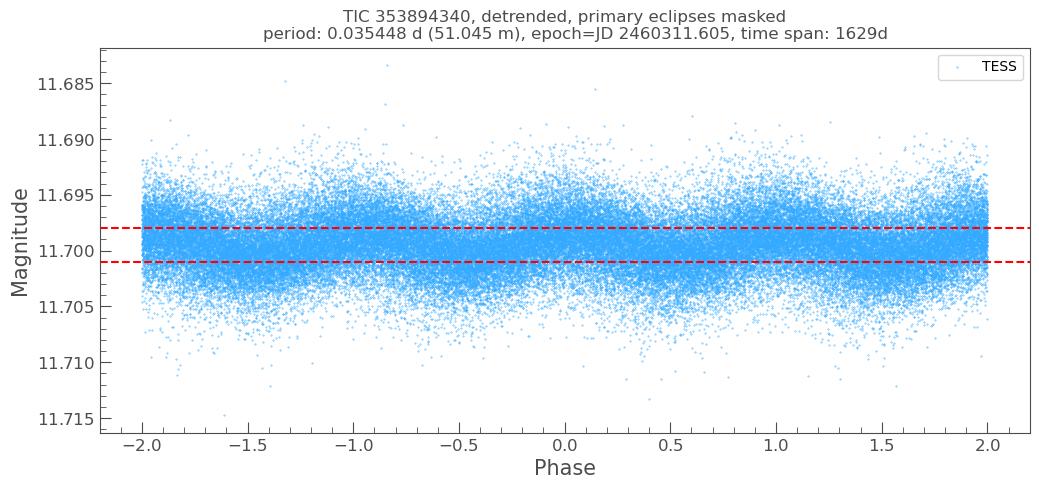

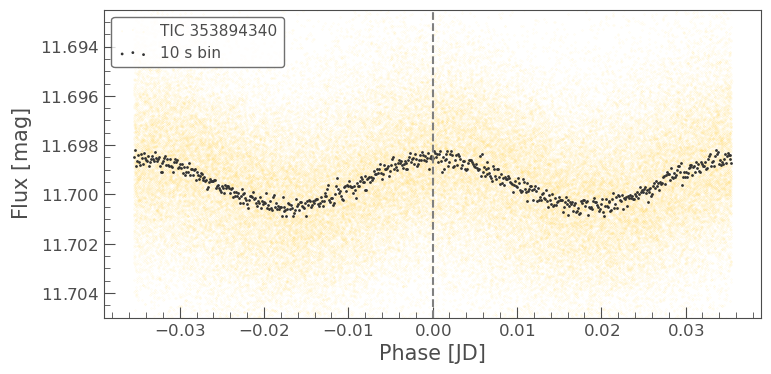

In [162]:
# Assign pulsation period, epoch
#
reload(lke)

period_puls = round(pg.period_at_max_power.value, 6)
                       
epoch_puls_btjd = 3311.606
epoch_puls_hjd = round(lke.to_hjd_utc(Time(epoch_puls_btjd, format="btjd"), target_coord).value, 3)

puls_min_mag = 11.701   # from binned LC
puls_max_mag = 11.698
puls_amplitude_mag = round(puls_min_mag - puls_max_mag, 3)

#
# Visualize the result
#

lc_puls = lke.to_flux_in_mag_by_normalization(
    lke.convert_lc_time_to_hjd_utc(
        lc_flattened, target_coord=target_coord, cache_dir=lk_download_dir, cache_key=f"tic{tic}_flattened"
    )
)

label = "TESS"

# lc_puls = lc_puls + lc_combined_dict["TESS"].flux_shift
# label = f"TESS + {lc_combined_dict['TESS'].flux_shift.value:.2f} mag"

ax, lc_f_res= lkem.fold_n_plot_multi_bands(
    {label: lc_puls},
    epoch=Time(epoch_puls_hjd, format="jd", scale="utc"),
    period=period_puls, 
    phase_scale=4, # use 4X to better see the min
    figsize=(12, 5),
    target_name=f"{primary_name}, detrended, primary eclipses masked",
)
ax.axhline(puls_min_mag, linestyle="--", c="red");
ax.axhline(puls_max_mag, linestyle="--", c="red");


# re-plot TESS in 2X with binning to check the epoch
lc_f = lc_puls.fold(period=period_puls * 2, epoch_time=epoch_puls_hjd);
ax = tplt.scatter(lc_f, color="gold", alpha=0.2, s=0.1);
lc_f_b = lke.bin_flux(lc_f, time_bin_size=10*u.s)
ax = tplt.scatter(lc_f_b, ax=ax, label="10 s bin");
ax.set_ylim(11.705, 11.6925);
ax.axvline(0, color="gray", linestyle="--");

print("Binned Max, min, amp:",lc_f_b.flux.min(), lc_f_b.flux.max(), lc_f_b.flux.max() - lc_f_b.flux.min())

_lc = lc_f_b.truncate(-0.01, 0.01)
print("Binned max phase:",_lc.time[np.argmin(_lc.flux)])

## Plots for VSX

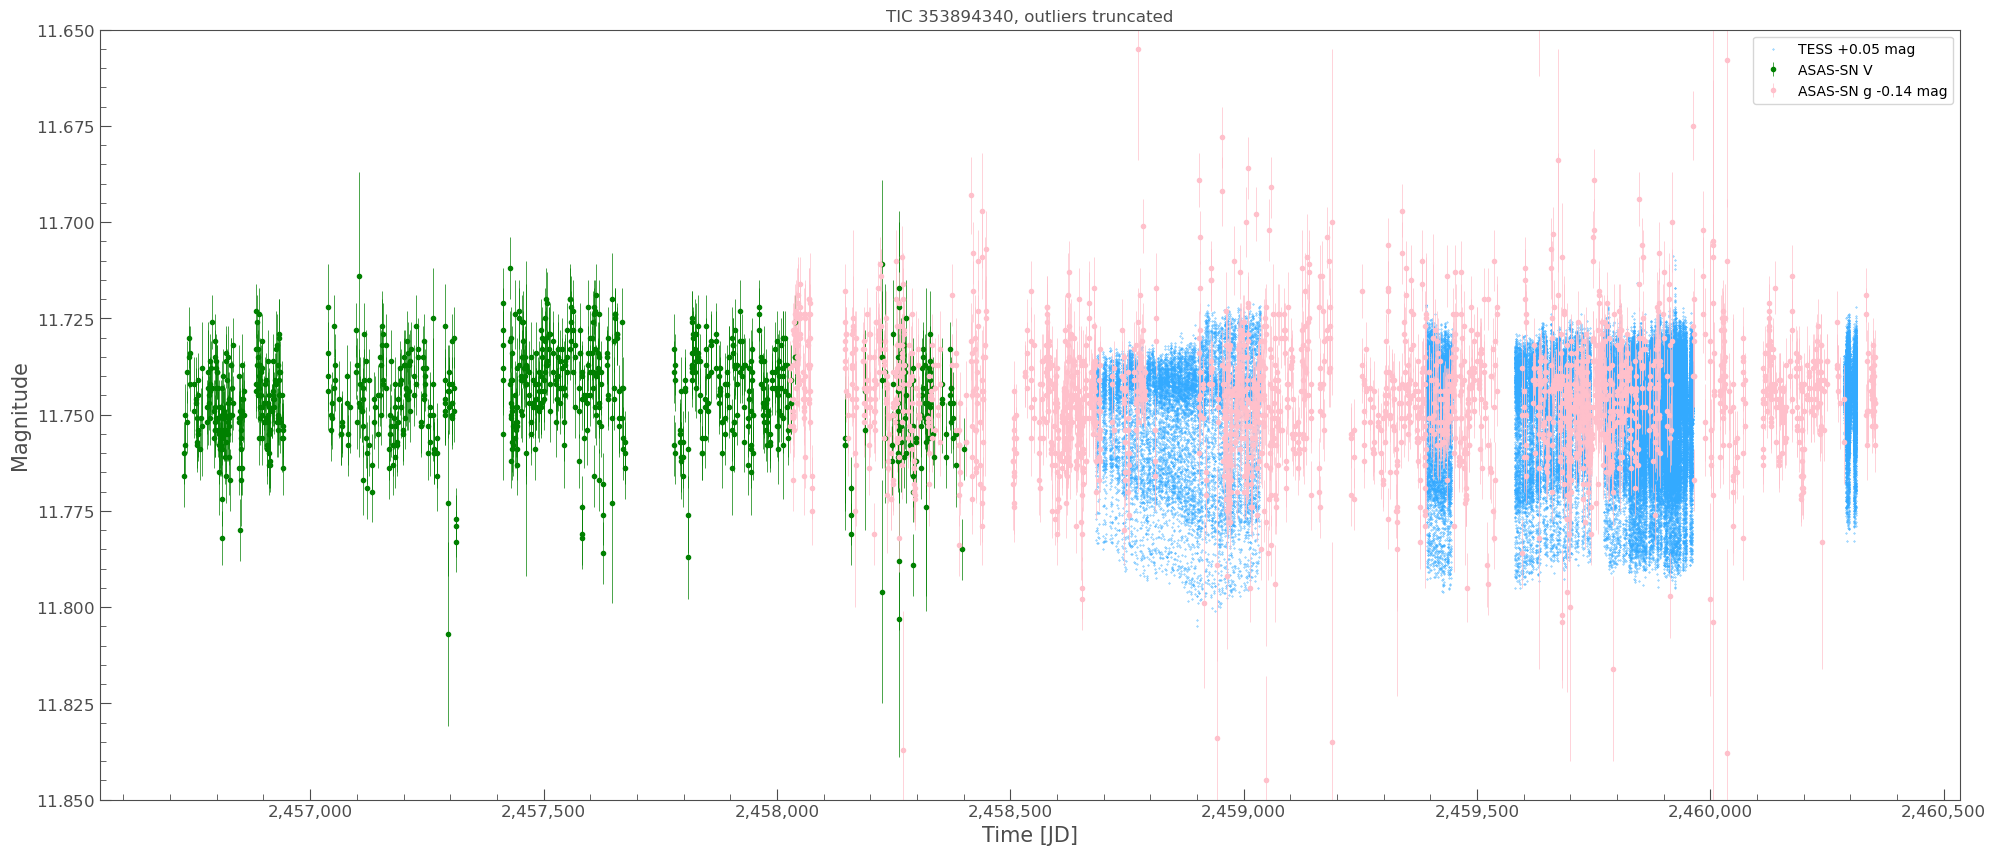

In [56]:
# reload(lkem)
ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name);
ax.set_ylim(11.85, 11.65);
ax.set_title(ax.get_title() + ", outliers truncated");

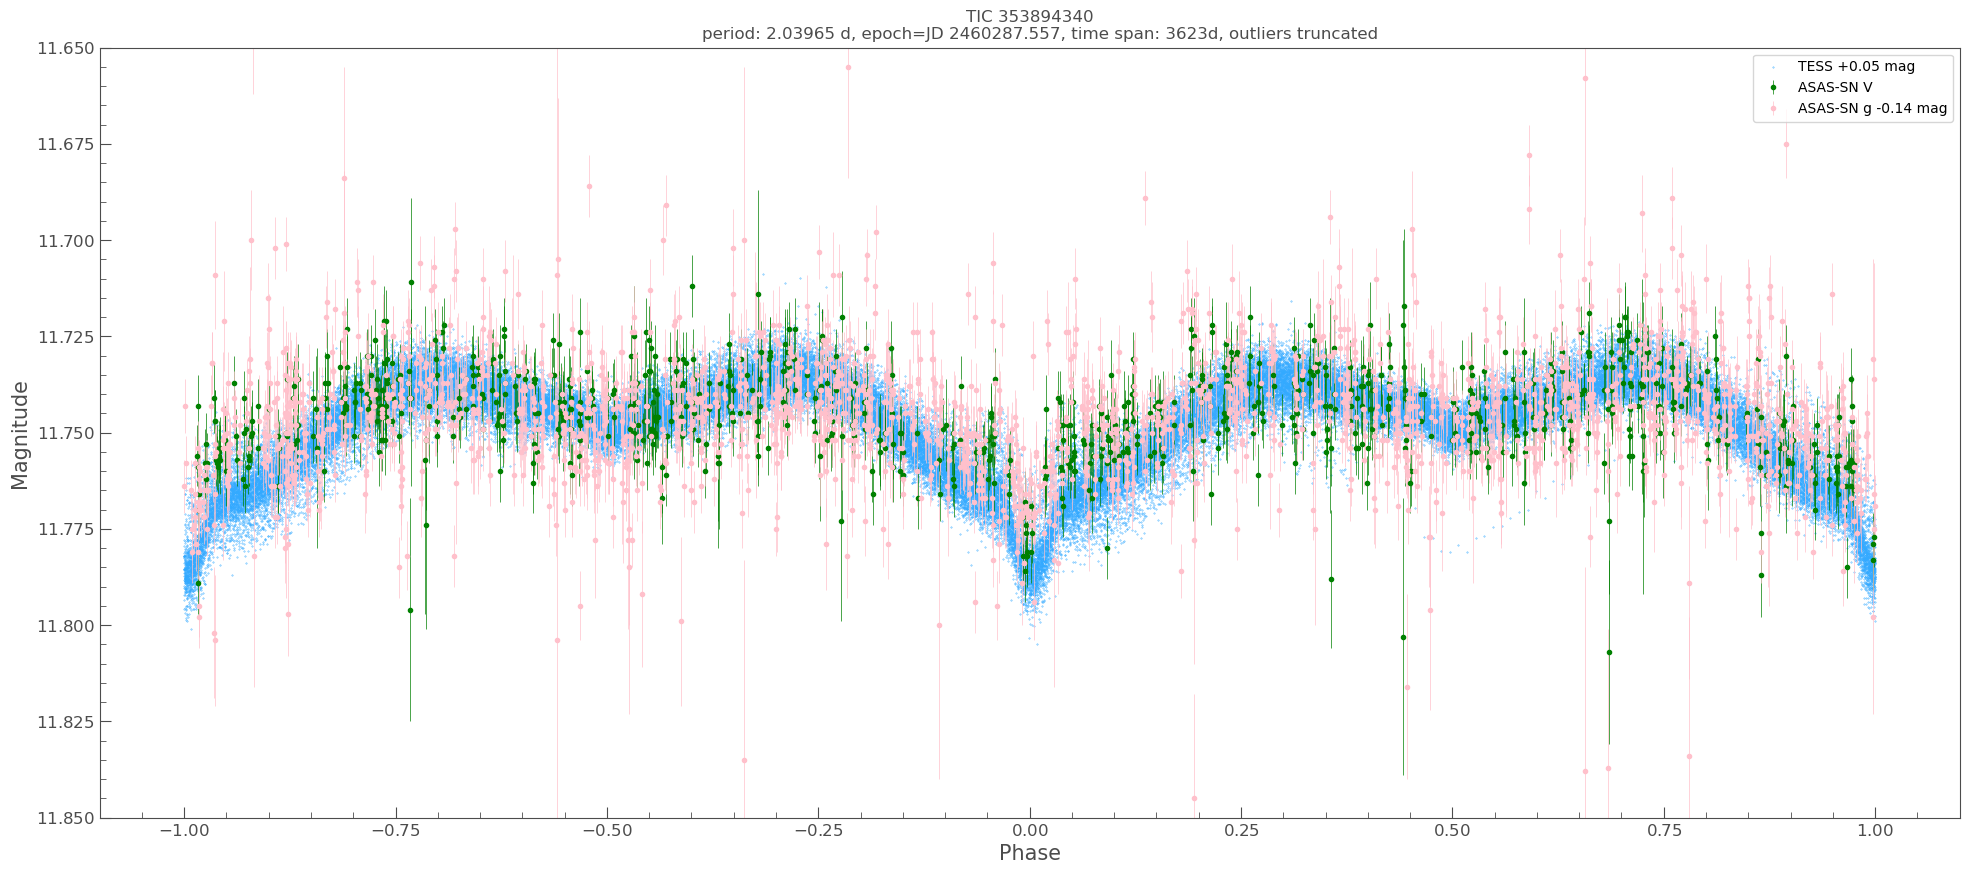

In [57]:
# reload(lkem)
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    figsize=(24, 10),
    target_name=primary_name,
);
ax.set_ylim(11.85, 11.65);
ax.set_title(ax.get_title() + ", outliers truncated");

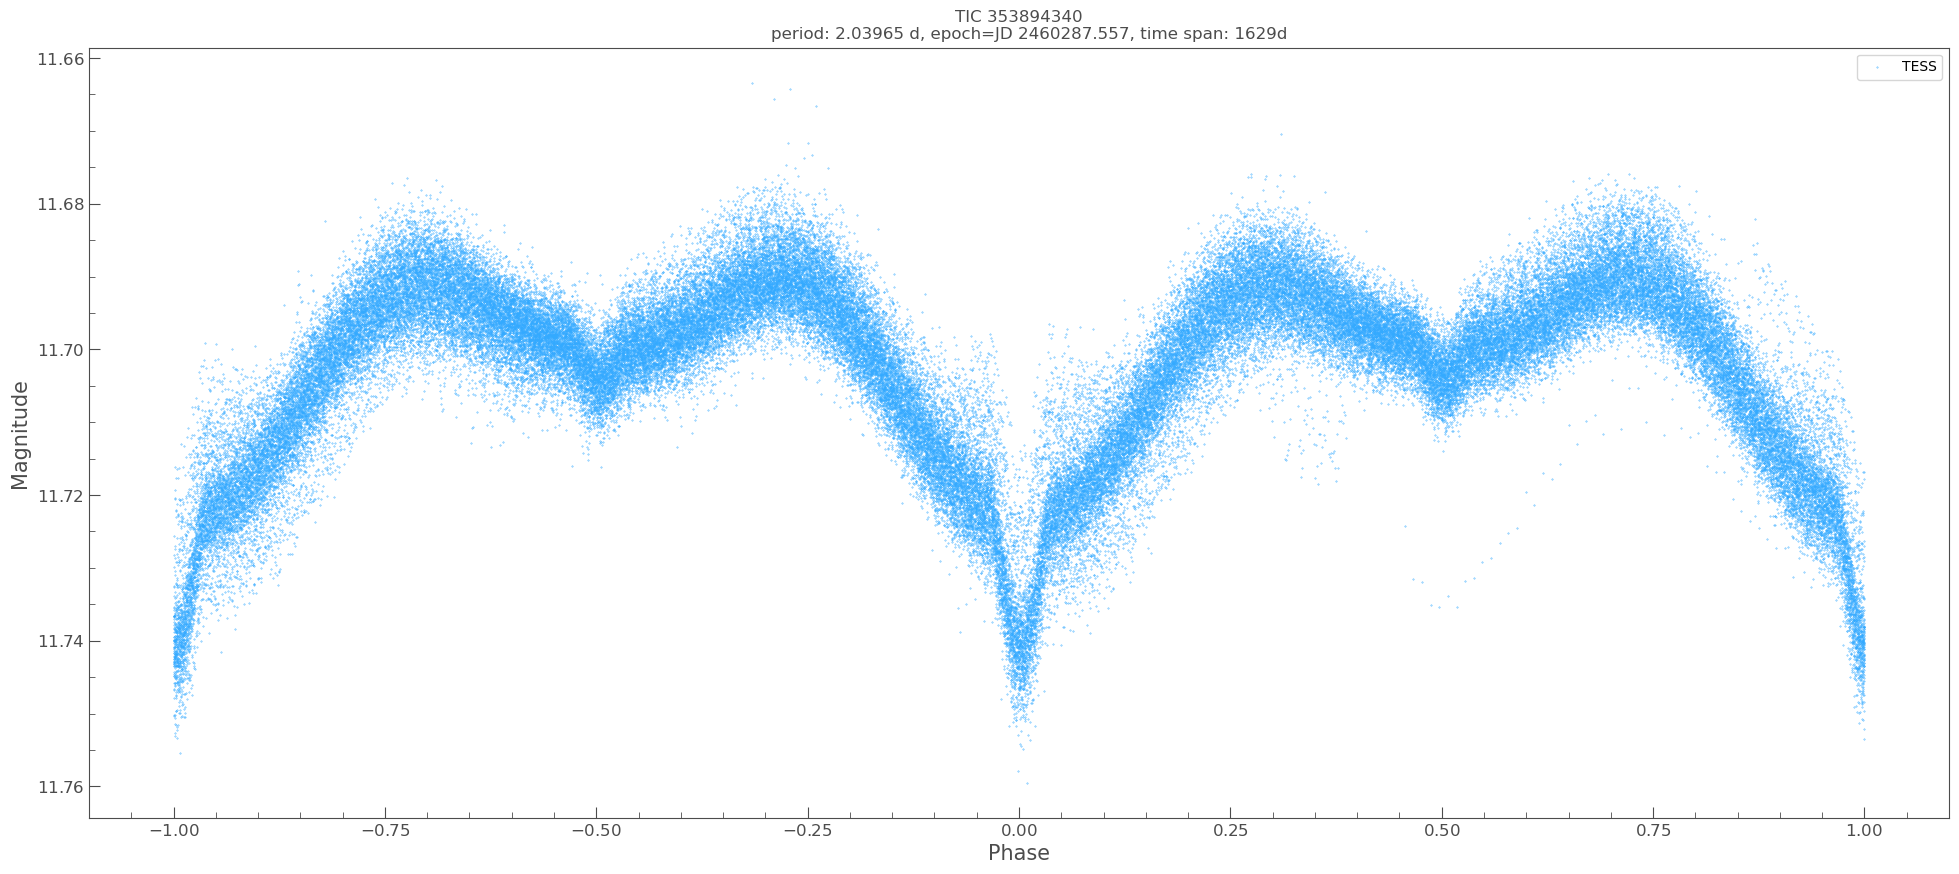

In [75]:
# reload(lkem)
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    dict(TESS=lc_tess),
    period=period_final,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    figsize=(24, 10),
    target_name=primary_name,
);
# ax.set_ylim(11.85, 11.65);
# ax.set_title(ax.get_title() + ", outliers truncated");

In [89]:
# Stick with the combined phase plot
#
# lc = lc_combined_dict["TESS"]  # unshfit back to TESS mag
# lc = lc - lc.flux_shift
# del lc.meta["FLUX_SHIFT"]

# ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#     {"TESS": lc},
#     period=period_final,
#     epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
#     phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
#     target_coord=target_coord,
#     figsize=(24, 10),
#     target_name=primary_name,
# );
# ax.set_ylabel("TESS Magnitude");

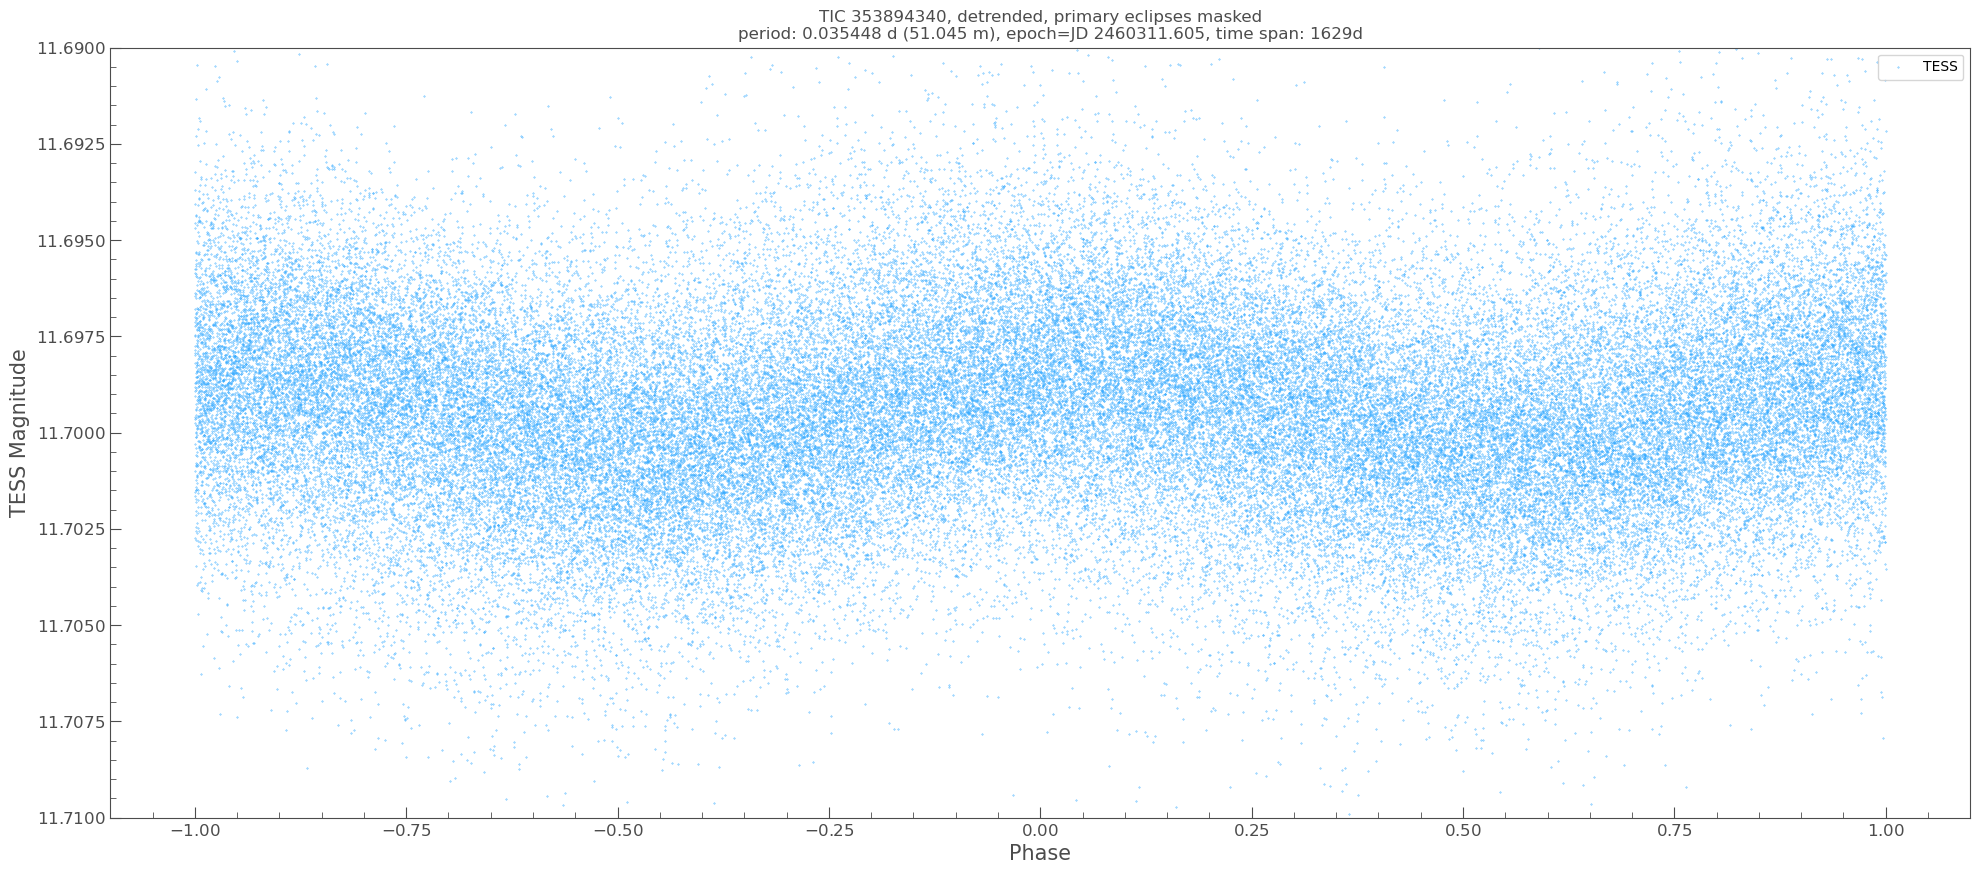

In [164]:
lc_puls = lke.to_flux_in_mag_by_normalization(
    lke.convert_lc_time_to_hjd_utc(
        lc_flattened, target_coord=target_coord, cache_dir=lk_download_dir, cache_key=f"tic{tic}_flattened"
    )
)

label = "TESS"

# lc_puls = lc_puls + lc_combined_dict["TESS"].flux_shift
# label = f"TESS + {lc_combined_dict['TESS'].flux_shift.value:.2f} mag"

ax, lc_f_res= lkem.fold_n_plot_multi_bands(
    {label: lc_puls},
    epoch=Time(epoch_puls_hjd, format="jd", scale="utc"),
    period=period_puls, 
    phase_scale=2,
    figsize=(24, 10),
    target_name=f"{primary_name}, detrended, primary eclipses masked",
)

ax.set_ylabel("TESS Magnitude");
ax.set_ylim(11.71, 11.69);

## VSX Report Table

In [63]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [165]:
import bibs_utils
reload(bibs_utils)


other_names = "TYC 3907-62-1,2MASS J18070164+5459106"  # Not in Gaia DR3 Variable
other_names += ",GSC 03907-00062,UCAC4 725-056880"  # from Sebatsian O

# GSC: https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/255/out
# GSC serach returns GSC 0390700062 in 2 rows, indicating the GSC id matches 2 objetcs. So for now I avoid from using it
#https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65cc1e7bc59c1&-to=-4b&-from=-3&-this=-4&%2F%2Fsource=I%2F255%2Fout&%2F%2Ftables=I%2F255%2Fout&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&-out.add=_r&%2F%2Foutaddvalue=default&-sort=_r&-order=I&-oc.form=sexa&-out.src=I%2F255%2Fout&-nav=cat%3AI%2F255%26tab%3A%7BI%2F255%2Fout%7D%26key%3Asource%3DI%2F255%2Fout%26pos%3A271.75686186442%2C+54.98630213781%28+++30+arcsec+J2000%29%26HTTPPRM%3A&-c=271.75686186442%2C+54.98630213781&-c.eq=J2000&-c.r=+30&-c.u=arcsec&-c.geom=r&-source=&-source=I%2F255%2Fout&-out=GSC&-out=RAJ2000&-out=DEJ2000&-out=PosErr&-out=Pmag&-out=e_Pmag&-out=n_Pmag&-out=Class&-out=Epoch&-meta.ucd=2&-meta=1&-meta.foot=1&-usenav=1&-bmark=GET

# the amplitudes suggested by Sebatsian O.
remarks = f"Min I amplitude 0.02 TESS. Min II amplitude 0.005 TESS. Ellipsoidal variations 0.03 TESS. DSCT period {period_puls} d. with amplitude {puls_amplitude_mag} TESS."
    
revision_comment = "Type, period, epoch, eclipse duration from TESS and ASAS-SN. Magnitudes from ASAS-SN V. Amplitudes from TESS. Spectral type and position from Gaia DR3."

BIBS = bibs_utils.BIBS

vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA+DSCT",
    Spectral_Type="A",  # from Gaia DR3 astrophysical parameters
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{max_flux_mag:.2f}",
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{min_flux_mag:.2f}",
    Minimum_Magnitude_band="V",  
    Minimum_Is_Amplitude=False,
    Period=period_final,
    Epoch=epoch_time_hjd,
    Rise_Duration_Pct=f"{100 * duration_hr / 24 / period_final:.0f}",
    Discoverer="",  #  The original entry https://www.aavso.org/vsx/index.php?view=detail.top&oid=625480 has no discoverer
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference2_Name=BIBS.TESS_SPOC_N,
    Reference2_Bib=BIBS.TESS_SPOC_B,
    Reference1_Name=BIBS.TESS_N,
    Reference1_Bib=BIBS.TESS_B,
    Reference3_Name=BIBS.QLP_N,
    Reference3_Bib=BIBS.QLP_B,
    Reference4_Name=BIBS.ASAS_SN_N,
    Reference4_Bib=BIBS.ASAS_SN_B,
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))

# Uploaded plots with  descriptions
print("""
tic353894340_combined_plot.png: Combined light curve - Combined light curve from ASAS-SN and TESS, shifted to ASAS-SN V, outliers truncated.
tic353894340_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot of the target from  ASAS-SN and TESS, shifted to ASAS-SN V, outliers truncated.
tic353894340_phase_plot_eclipses_tess.png : EA Phase Plot (TESS only) - EA Phase Plot of the target from TESS.
tic353894340_phase_plot_pulsation.png : Pulsation Phase Plot - Pulsation Phase Plot of the target from detrended TESS, outliers truncated.
""")


Other Names (1 line each):
TYC 3907-62-1
2MASS J18070164+5459106
GSC 03907-00062
UCAC4 725-056880

Min I amplitude 0.02 TESS. Min II amplitude 0.005 TESS. Ellipsoidal variations 0.03 TESS. DSCT period 0.035448 d. with amplitude 0.003 TESS.

Type, period, epoch, eclipse duration from TESS and ASAS-SN. Magnitudes from ASAS-SN V. Amplitudes from TESS. Spectral type and position from Gaia DR3.


Field  \
0                  Position   
1              Primary_Name   
2               Other_Names   
3             Variable_Type   
4             Spectral_Type   
5   Spectral_Type_Uncertain   
6         Maximum_Magnitude   
7    Maximum_Magnitude_band   
8         Minimum_Magnitude   
9    Minimum_Magnitude_band   
10     Minimum_Is_Amplitude   
11                   Period   
12                    Epoch   
13        Rise_Duration_Pct   
14               Discoverer   
15                  Remarks   
16         Revision_Comment   
17          Reference2_Name   
18           Reference2_Bib   
19          Reference1_Name   
20           Reference1_Bib   
21          Reference3_Name   
22           Reference3_Bib   
23          Reference4_Name   
24           Reference4_Bib   

                                                                                                                                                      Value  
0                                                                                                                           271.75686186442, 54.98630213781  
1                                                                                                                                             TIC 353894340  
2                                                                                    TYC 3907-62-1,2MASS J18070164+5459106,GSC 03907-00062,UCAC4 725-056880  
3                                                                                                                                                   EA+DSCT  
4                                                                                                                                                         A  
5                                                                                                                                                     False  
6                                                                                                                                                     11.73  
7                                                                                                                                                         V  
8                                                                                                                                                     11.78  
9                                                                                                                                                         V  
10                                                                                                                                                    False  
11                                                                                                                                                  2.03965  
12                                                                                                                                              2460287.557  
13                                                                                                                                                        7  
14                                                                                                                                                           
15             Min I amplitude 0.02 TESS. Min II amplitude 0.005 TESS. Ellipsoidal variations 0.03 TESS. DSCT period 0.035448 d. with amplitude 0.003 TESS.  
16  Type, period, epoch, eclipse duration from TESS and ASAS-SN. Magnitudes from ASAS-SN V. Amplitudes from TESS. Spectral type and position from Gaia DR3.  
17                                                        Caldwell, D. A.; et al., 2020, TESS Science Processing Operations Center FFI Target List Products  
18                                                                                                                                      2020RNAAS...4..201C  
19                                                     


tic353894340_combined_plot.png: Combined light curve - Combined light curve from ASAS-SN and TESS, shifted to ASAS-SN V, outliers truncated.
tic353894340_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot of the target from  ASAS-SN and TESS, shifted to ASAS-SN V, outliers truncated.
tic353894340_phase_plot_eclipses_tess.png : EA Phase Plot (TESS only) - EA Phase Plot of the target from TESS.
tic353894340_phase_plot_pulsation.png : Pulsation Phase Plot - Pulsation Phase Plot of the target from detrended TESS, outliers truncated.



# Scratch